# MinHash Jaccard Index benchmarks
In this jupyter notebook we explore the performance of MinHash on the estimation of Jaccard Index. Specifically, we explore several MinHash parametrization, including different words (u8, u16, u32 and u64), and number of permutations. We will compare the performance of MinHash with the performance of several different parametrization of [HyperLogLog](https://github.com/LucaCappelletti94/hyperloglog-rs) so to determine the regions where, if any, MinHash is preferable to HyperLogLog. We explore universes with different cardinalities, including 10, 100, 1000, 10k, 100k, 1M, 10M and 100M. We compare the two main methods at parity of memory requirements and time requirements.

## Relevant vocabulary terms you may need
In this introductory section, I tried to include definitions of several terms used across this notebook that a layman may not be familiar with. Feel free to skip it if you believe you are generally familiar with the subject.

### What is a word in computer science?
With the term 'word', we refer to a fixed-size unit of data that a computer processes as a single entity. It is typically determined by the system's architecture and is used to represent and manipulate data in memory. Words have a specific size, such as 32 bits or 64 bits, and are used for storing variables, instructions, and memory addresses. They are fundamental to low-level operations and memory management in computer systems.

### What is a random number generator?
A random number generator (RNG) is a computational algorithm or physical device that produces a sequence of numbers that appear to be statistically random. It is used in various fields, including computer science, cryptography, simulations, and gaming. RNGs aim to generate numbers that are unpredictable and lack any discernible pattern or correlation. They can be classified into two categories: pseudo-random number generators (PRNGs) and true random number generators (TRNGs). PRNGs use deterministic algorithms to produce a sequence of numbers that, while not truly random, exhibit properties that approximate randomness. TRNGs, on the other hand, rely on physical processes or phenomena, such as atmospheric noise or radioactive decay, to generate truly random numbers. The choice of RNG depends on the specific requirements of the application, with PRNGs suitable for most cases and TRNGs preferred for applications requiring high levels of unpredictability and entropy.

### What is SplitMix?
[SplitMix](https://dl.acm.org/doi/10.1145/2660193.2660195) is a simple and fast pseudo-random number generator (PRNG) algorithm. It is commonly used as a basic building block for more complex PRNGs or as a standalone generator for simple applications. The SplitMix algorithm operates by repeatedly splitting and mixing a 64-bit seed value to produce a sequence of 64-bit pseudo-random numbers. It provides good statistical properties and exhibits a large period, which is the number of unique values it can generate before repeating. SplitMix is known for its speed and simplicity, making it a popular choice when efficiency is a priority. However, it should be noted that SplitMix is not suitable for cryptographic applications that require high levels of security or unpredictability.

```python
def splitmix(seed):
    seed += 0x9e3779b97f4a7c15
    seed = (seed ^ (seed >> 30)) * 0xbf58476d1ce4e5b9
    seed = (seed ^ (seed >> 27)) * 0x94d049bb133111eb
    return seed ^ (seed >> 31)
```

### What is XorShift?
[Xorshift](https://www.jstatsoft.org/article/download/v008i14/916) is a family of pseudo-random number generator (PRNG) algorithms known for their simplicity and speed. These algorithms use bitwise XOR (exclusive OR) and bit-shifting operations to generate a sequence of pseudo-random numbers. The name "xorshift" comes from the primary operations it utilizes. Xorshift algorithms typically employ a state variable that is updated by performing XOR and shift operations to produce the next pseudo-random number. Different variations of xorshift exist, such as xorshift32, xorshift64, and xorshift128, which differ in the size of their state variables and the specific bit operations used. Xorshift algorithms are relatively easy to implement and offer reasonable statistical properties and speed, making them suitable for many applications where high cryptographic security is not a requirement.

```python
def xorshift(seed):
    seed ^= (seed << 13)
    seed ^= (seed >> 17)
    seed ^= (seed << 5)
    return seed
```

### What is the Mean Squared Error?
[Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) is a commonly used statistical measure to assess the average squared difference between predicted and actual values. It is a metric that quantifies the average magnitude of the error or discrepancy between the predicted values from a model or estimator and the corresponding true values in a dataset.

To calculate the mean squared error, you take the difference between each predicted value and its corresponding true value, square the differences, sum them up, and then divide by the total number of observations. The formula for MSE is as follows:

$$MSE(y, \hat{y}) = \frac{1}{n} \sum_{i}^{n} (y_i - \hat{y}_i)^2$$

## What is the Jaccard Index?
The Jaccard Index was proposed by Paul Jaccard in the lovely names paper ["The distribution of Flora in the Alpine zone"](https://nph.onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8137.1912.tb05611.x) from 1912, over 100 years ago. It is a measure of similarity between two sets. It is defined as the size of the intersection divided by the size of the union of the two sets. It is a number between 0 and 1, where 0 means that the two sets are disjoint, and 1 means that the two sets are identical. It is a very simple and intuitive measure of similarity between two sets. It is also known as the Jaccard similarity coefficient.

$$J(A, B) = \frac{\lvert A \cap B\rvert}{\lvert A \cup B\rvert}$$

## What is MinHash?
The [MinHash data structure](https://ieeexplore.ieee.org/abstract/document/666900/) is a probabilistic technique used for estimating the similarity between sets. It is particularly useful for large-scale data analysis and tasks like document similarity, recommendation systems, and clustering. At its core, MinHash represents a set by constructing a signature or fingerprint using a fixed-size array of hash values. The "number of permutations" parameter refers to the number of hash functions used to generate the MinHash signature. Each hash function corresponds to a permutation, and the resulting array of hash values captures the ordering of elements within the set. By comparing the MinHash signatures of different sets, the Jaccard similarity coefficient can be approximated, providing a measure of their similarity. The number of permutations determines the trade-off between accuracy and computational efficiency. A higher number of permutations generally leads to more accurate similarity estimates but requires increased computational resources for processing.

### Representing a set in a MinHash data structure
A MinHash data structure is a fixed-size array of hash values. Each hash value is the result of a hash function applied to the set. The number of hash functions is equal to the number of permutations. In the following example we will be using several calling to the python hash function as the hash for the various buckets, but any arbitrary set of hash functions may be used. In the Rust implementation available in [this repository](https://github.com/LucaCappelletti94/minhash-rs) we are using a [SipHasher13](https://eprint.iacr.org/2014/722) followed by a [SplitMix](https://dl.acm.org/doi/10.1145/2660193.2660195) and then a number of [XorShift](https://www.jstatsoft.org/article/download/v008i14/916) for all the permutations.

```python

set_to_digest = {"A", "B", ..., "All hail Cthulhu"}
number_of_permutations = 128
minhash = [
    float("inf")
    for _ in range(number_of_permutations)
]

for element in set_to_digest:
    hashed_element = hash(element)
    for i in range(number_of_permutations):
        minhash[i] = min(minhash[i], hashed_element)
        hashed_element = hash(hashed_element)
```

### Merging two MinHash data structures
Given two MinHash data structures, you can merge the sets in a probabilistic manner by computing the minimum value element-wise.

```python
def merge(minhash_a, minhash_b):
    return [
        min(minhash_a[i], minhash_b[i])
        for i in range(len(minhash_a))
    ]
```

### Estimating the Jaccard Index from two MinHash data structures
Given two MinHash data structures, you can estimate the Jaccard Index of the sets associated to them by computing the number of the values that are identical, divided by the number of permutations.

```python
def jaccard_index(minhash_a, minhash_b):
    return sum(
        minhash_a[i] == minhash_b[i]
        for i in range(len(minhash_a))
    ) / len(minhash_a)
```

## HyperLogLog
[HyperLogLog](https://github.com/LucaCappelletti94/hyperloglog-rs) is a probabilistic algorithm used for estimating the cardinality (number of distinct elements) of a large set, while conserving memory. It is widely used in data engineering, analytics, and databases. HyperLogLog achieves memory efficiency by employing a fixed amount of memory, regardless of the size of the input set.

The algorithm works by hashing each element of the input set and then analyzing the binary representation of the hash values. It counts the length of the longest run of leading zeros in each hashed value and stores this information in a set of registers.

The number of registers in a HyperLogLog data structure determines the accuracy of the cardinality estimation. More registers lead to better precision but require additional memory. By using clever statistical approximations, HyperLogLog can achieve accurate cardinality estimates with an expected error rate of around 1.04/sqrt(m), where m is the number of registers.

To obtain the estimated cardinality, the register values are combined and processed using a harmonic mean or other techniques. The final result provides an approximation of the distinct element count of the input set.

HyperLogLog is a valuable tool for applications that require fast and memory-efficient cardinality estimation, such as large-scale analytics, distributed systems, and data stream processing. However, it is important to note that HyperLogLog is an approximate algorithm and may introduce a small error in the estimated cardinality.

### Computing the Jaccard index between HyperLogLog representations
While HyperLogLog is commonly known for its ability to estimate the union of multiple sets with limited memory usage, it can also be leveraged to compute the Jaccard index. To compute the Jaccard index between two sets represented by HyperLogLog data structures, we can follow these steps:

1. Estimate the cardinality of each set using HyperLogLog. This involves creating separate HyperLogLog data structures for each set and inserting the elements of the respective sets into them. Most commonly, we do not actually have sets but stream of data that cannot be actually stored in memory due to their size.

2. Compute the union cardinality, which can be estimated by creating a third HyperLogLog data structure and merging the two HyperLogLog data structures from the previous step. The register of this third HyperLogLog are equal to the register-wise maximum value.

3. Once we have the union cardinality, we can use the well known formula from set theory to compute the cardinality of the intersection:

$$\lvert A \cap B \rvert = \lvert A \rvert + \lvert B \rvert - \lvert A \cup B \rvert $$

It is worth noting that while HyperLogLog provides a memory-efficient approach for estimating set cardinalities and Jaccard indices, the accuracy of the Jaccard index computation can be affected by the inherent approximation of the HyperLogLog algorithm. Therefore, it is crucial to consider the expected error rate of the HyperLogLog estimates when interpreting the Jaccard index results.

### What is a register in a HyperLogLog data structure?
A register is a fixed-size unit of data that stores information in a HyperLogLog data structure. It is typically represented as a 5- or 6-bit integer and is used to store the length of the longest run of leading zeros in a hashed value. The number of registers in a HyperLogLog data structure determines the accuracy of the cardinality estimation. More registers lead to better precision but require additional memory.

Please do note that these registers have nothing to do with CPU registers, which are a different concept used in computer architecture. CPU registers are small, fast storage locations within the central processing unit (CPU) that hold data being actively processed by the CPU. They are used for storing intermediate results, memory addresses, and operands during program execution. CPU registers are part of the hardware architecture and are unrelated to the registers used in the context of HyperLogLog or other probabilistic data structures.

### Register size in HyperLogLog counters
In HyperLogLog counters, the register size refers to the number of bits used to store information in each register of the data structure. The register size significantly impacts the accuracy of cardinality estimation and the memory requirements of the HyperLogLog implementation.

In this version of HyperLogLog, the exploration includes register sizes of 1, 2, 3, 4, 5, and 6 bits. However, it's important to note that in concrete use cases, register sizes of 5 or 6 bits are commonly employed due to the trade-off between memory efficiency and accuracy.

Smaller register sizes, such as 1 or 2 bits, provide memory savings but result in increased error rates and less precise cardinality estimation. Conversely, larger register sizes, such as 5 or 6 bits, offer improved accuracy at the cost of increased memory usage. These larger register sizes strike a balance between accuracy and memory efficiency, making them popular choices in practice.

The choice of register size in a HyperLogLog implementation depends on factors like the desired accuracy level, available memory constraints, and the cardinality range of the data set. In most scenarios, register sizes of 5 or 6 bits are recommended as they provide reasonably accurate estimations while still maintaining memory efficiency.

## On the absence of standard deviation in the figures
While we have executed several runs of the benchmarks changing the random states to obtain performance that account at least in part for the noise, we need to illustrate the values in Log scale since the values vary by a large amount. If we were to also include the standard deviations in the visualizations, in the log scale it may require for us to visualize negative values which is not possible. For this reason, we have decided to not include the standard deviations in the visualizations. However, we have included the standard deviations in the tables.

## Reproducing the benchmarks
The benchmarks are available as part of the [minhash-rs](https://github.com/LucaCappelletti94/minhash-rs) Rust crate test suite. Note that the benchmark require **DAYS** to run on a consumer grade machine. Yeah, it was quite painful to get these results - even in this rather clean implementation of MinHash we have discovered it is not . For this reason, we have included the results of the benchmarks in the `tests` folder (all of those `*.csv.gz` you find in there). If you wish to reproduce the benchmarks, you can do so by running the following command:

```bash
cargo test --release -- --nocapture
```

The `-- --nocapture` bit is so you see the loading bar. Please be advised that the test is, by default, disabled as it takes a lot of time to run. If you wish to run it, you need to enable it `tests/test_jaccard.rs` file. 

We import utilities that we are going to use for the visualizations:

In [9]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from glob import glob

Since the uncompressed CSVs are quite large, we compress them to make them loadable onto GitHub (and so you guys can actually check them out).

In [10]:
for path in glob("tests/*.csv"):
    pd.read_csv(path).to_csv(f"{path}.gz", index=False)

We start by loading the results relative to MinHash. Here the parameters being explored are the number of permutations, where the possible values are 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096 and 8192, and the word used for the MinHash hashes, which includes u8, u16, u32 and u64.

In [11]:
minhash = pd.read_csv("tests/test_minhash_jaccard_large.csv.gz",)

minhash["mse"] = (minhash["approximation"] - minhash["ground_truth"])**2
minhash_across_all = minhash.groupby(["permutations", "word", "memory"]).agg(["mean", "std", "count"]).reset_index()
minhash = minhash.groupby(["elements", "permutations", "word", "memory"]).agg(["mean", "std", "count"]).reset_index()
minhash

elements permutations word  memory approximation                  \
                                                  mean       std count   
0           10            2  u16      32      0.333333  0.258199     6   
1           10            2  u32      64      0.416667  0.376386     6   
2           10            2  u64     128      0.333333  0.408248     6   
3           10            2   u8      16      0.500000  0.316228     6   
4           10            4  u16      64      0.250000  0.158114     6   
..         ...          ...  ...     ...           ...       ...   ...   
411  100000000         4096   u8   32768      1.000000  0.000000     6   
412  100000000         8192  u16  131072      1.000000  0.000000     5   
413  100000000         8192  u32  262144      0.462817  0.003682     5   
414  100000000         8192  u64  524288      0.463599  0.008792     5   
415  100000000         8192   u8   65536      1.000000  0.000000     6   

    ground_truth                          time                           mse  \
            mean       std count          mean           std count      mean   
0       0.418585  0.194388     6  0.000000e+00  0.000000e+00     6  0.107165   
1       0.418585  0.194388     6  0.000000e+00  0.000000e+00     6  0.031107   
2       0.418585  0.194388     6  0.000000e+00  0.000000e+00     6  0.108488   
3       0.418585  0.194388     6  0.000000e+00  0.000000e+00     6  0.075154   
4       0.418585  0.194388     6  0.000000e+00  0.000000e+00     6  0.037886   
..           ...       ...   ...           ...           ...   ...       ...   
411     0.462118  0.000023     6  1.927642e+09  1.244271e+06     6  0.289318   
412     0.462114  0.000024     5  3.238815e+09  2.471951e+06     5  0.289321   
413     0.462114  0.000024     5  3.427828e+09  2.596374e+06     5  0.000011   
414     0.462114  0.000024     5  3.429551e+09  3.245645e+06     5  0.000064   
415     0.462118  0.000023     6  3.855576e+09  2.260915e+06     6  0.289318   

                     
          std count  
0    0.199600     6  
1    0.032065     6  
2    0.110249     6  
3    0.091107     6  
4    0.025115     6  
..        ...   ...  
411  0.000025     6  
412  0.000026     5  
413  0.000011     5  
414  0.000051     5  
415  0.000025     6  

[416 rows x 16 columns]

We do the same for the HyperLogLog benchmarks, where we explore different possible values of bits per register, including 1, 2, 3, 4, 5 and 6. Do note that, since the word used for the HyperLogLog counters is always a u32, we include the padding in the memory requirements when present. While it is conceivable to reduce the padding by using registers that overlap between different words, this is not available in the [HyperLogLog](https://github.com/LucaCappelletti94/hyperloglog-rs) implementation we are using. The reason for the feature being unavailable is primarily related to the fact that handling registers overlapping between words may introduce complexity and slow down the procedure for relatively small memory savings.

In [12]:
hll = pd.read_csv("tests/test_hll_jaccard_large.csv.gz",)

hll["mse"] = (hll["approximation"] - hll["ground_truth"])**2
hll_across_all = hll.groupby(["bits", "memory",]).agg(["mean", "std", "count"]).reset_index()
hll = hll.groupby(["elements", "bits", "memory",]).agg(["mean", "std", "count"]).reset_index()
hll.sort_values("memory")

elements bits  memory precision                 approximation            \
                                 mean       std count          mean       std   
0           10    1      32       4.5  0.522233    12      0.501866  0.275345   
462   10000000    1      32       4.5  0.522233    12      1.000000  0.000000   
12          10    2      32       4.0  0.000000     6      0.446356  0.246000   
77         100    1      32       4.5  0.522233    12      0.867086  0.128356   
397    1000000    2      32       4.0  0.000000     6      1.000000  0.000000   
..         ...  ...     ...       ...       ...   ...           ...       ...   
230       1000    6  393240      16.0  0.000000     6      0.454203  0.011956   
153        100    6  393240      16.0  0.000000     6      0.482380  0.029872   
76          10    6  393240      16.0  0.000000     6      0.418559  0.194396   
538   10000000    6  393240      16.0  0.000000     6      0.461405  0.001184   
615  100000000    6  393240      16.0  0.000000     6      0.459738  0.002202   

          ground_truth                          time                      \
    count         mean       std count          mean           std count   
0      12     0.418585  0.185342    12  2.500000e-01      0.621582    12   
462    12     0.462027  0.000060    12  1.270705e+05   1153.225713    12   
12      6     0.418585  0.194388     6  0.000000e+00      0.000000     6   
77     12     0.482633  0.028473    12  1.000000e+00      0.000000    12   
397     6     0.462042  0.000443     6  1.241550e+04     43.482180     6   
..    ...          ...       ...   ...           ...           ...   ...   
230     6     0.455562  0.013189     6  9.300000e+01      6.418723     6   
153     6     0.482633  0.029863     6  7.733333e+01      0.816497     6   
76      6     0.418585  0.194388     6  7.716667e+01      0.408248     6   
538     6     0.462027  0.000063     6  1.364432e+05   2099.655535     6   
615     6     0.462118  0.000023     6  1.284317e+06  20850.624004     6   

              mse                      
             mean           std count  
0    4.922207e-02  1.041842e-01    12  
462  2.894154e-01  6.506870e-05    12  
12   4.284014e-03  4.935499e-03     6  
77   1.602148e-01  8.373562e-02    12  
397  2.893992e-01  4.768000e-04     6  
..            ...           ...   ...  
230  5.024388e-06  5.453777e-06     6  
153  6.439222e-08  6.038135e-09     6  
76   7.146080e-10  4.026382e-10     6  
538  1.579758e-06  2.392633e-06     6  
615  9.728841e-06  9.456959e-06     6  

[616 rows x 18 columns]

## MSE per memory requirements
In the following cell we plot, for all different eight universe sizes, the MSE of the Jaccard Index estimation as a function of the memory requirements. We do so for both MinHash and HyperLogLog. Note that both the X and Y axes are in log scale.

We observe that the general trend is for the HyperLogLog counters of registers with 5 or 6 bits to beat any parametrization of MinHash for any compared memory requirement.

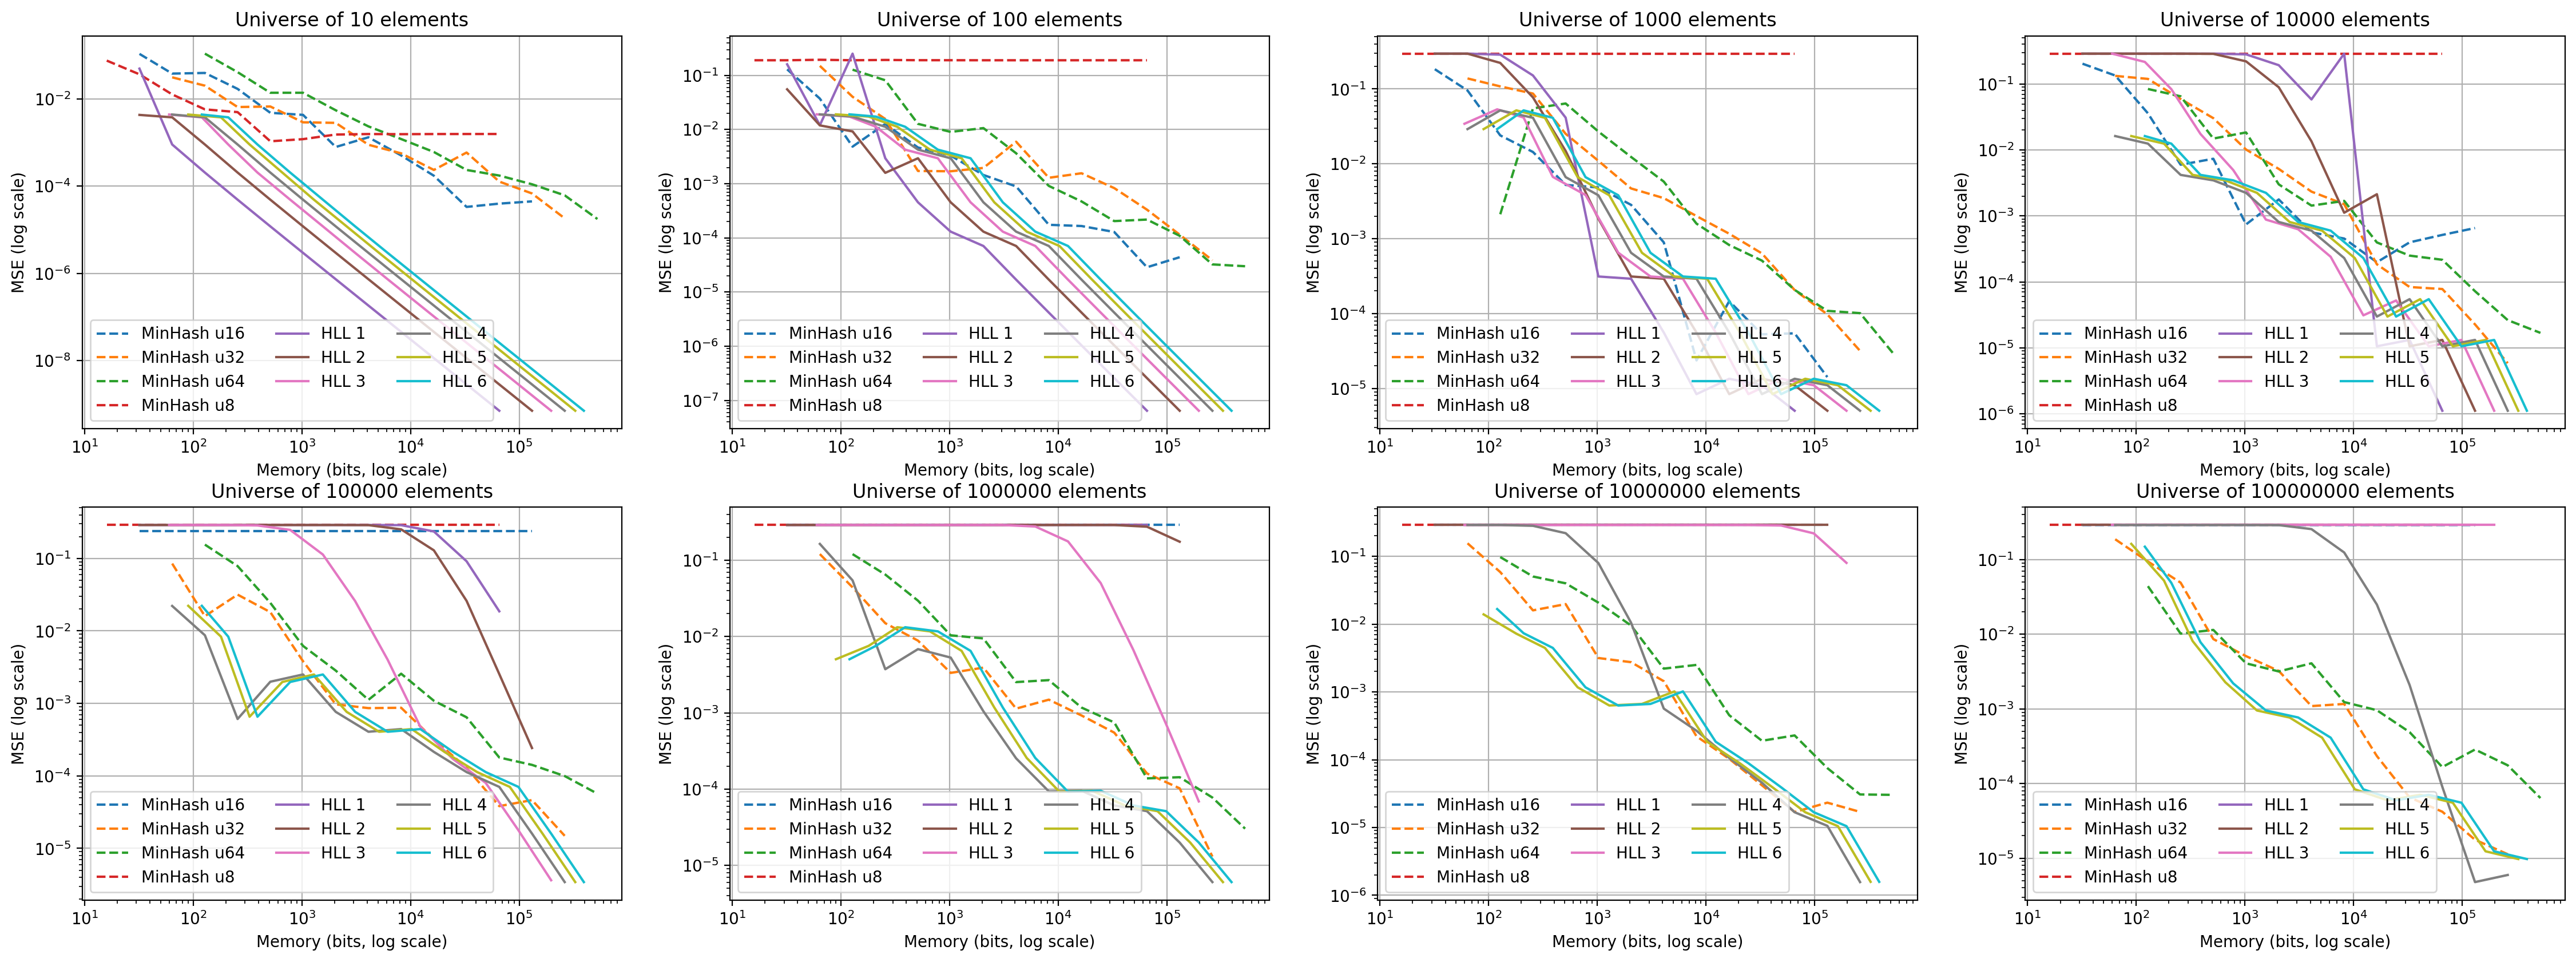

In [13]:
plots_per_row = 4
number_of_rows = math.ceil(len(hll.elements.unique()) / plots_per_row)

fig, axes = plt.subplots(
    figsize=(plots_per_row*7, 5*number_of_rows),
    nrows=number_of_rows,
    ncols=plots_per_row,
    dpi=200
)

for elements, ax in zip(hll.elements.unique(), axes.flatten()):
    for word in minhash.word.unique():
        filtered = minhash[(minhash.word == word) & (minhash.elements == elements)].sort_values("memory")
        ax.plot(
            filtered.memory,
            filtered["mse"]["mean"],
            ls='--',
            label=f"MinHash {word}",
        )
    for bits in hll.bits.unique():
        filtered = hll[(hll.bits == bits) & (hll.elements == elements)].sort_values("memory")
        ax.plot(
            filtered.memory,
            filtered["mse"]["mean"],
            label=f"HLL {bits}",
        )
    ax.set_title(f"Universe of {elements} elements")
    ax.set_xlabel(f"Memory (bits, log scale)")
    ax.set_ylabel(f"MSE (log scale)")
    ax.legend(ncol=3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()

plt.show()

## MSE per time requirement
In the following cell we plot, for all different eight universe sizes, the MSE of the Jaccard Index estimation as a function of the time requirements. We do so for both MinHash and HyperLogLog. Note that both the X and Y axes are in log scale.

**We observe that HyperLogLog time requirements are colossaly smaller by orders of magnitude when compared to MinHash's.**

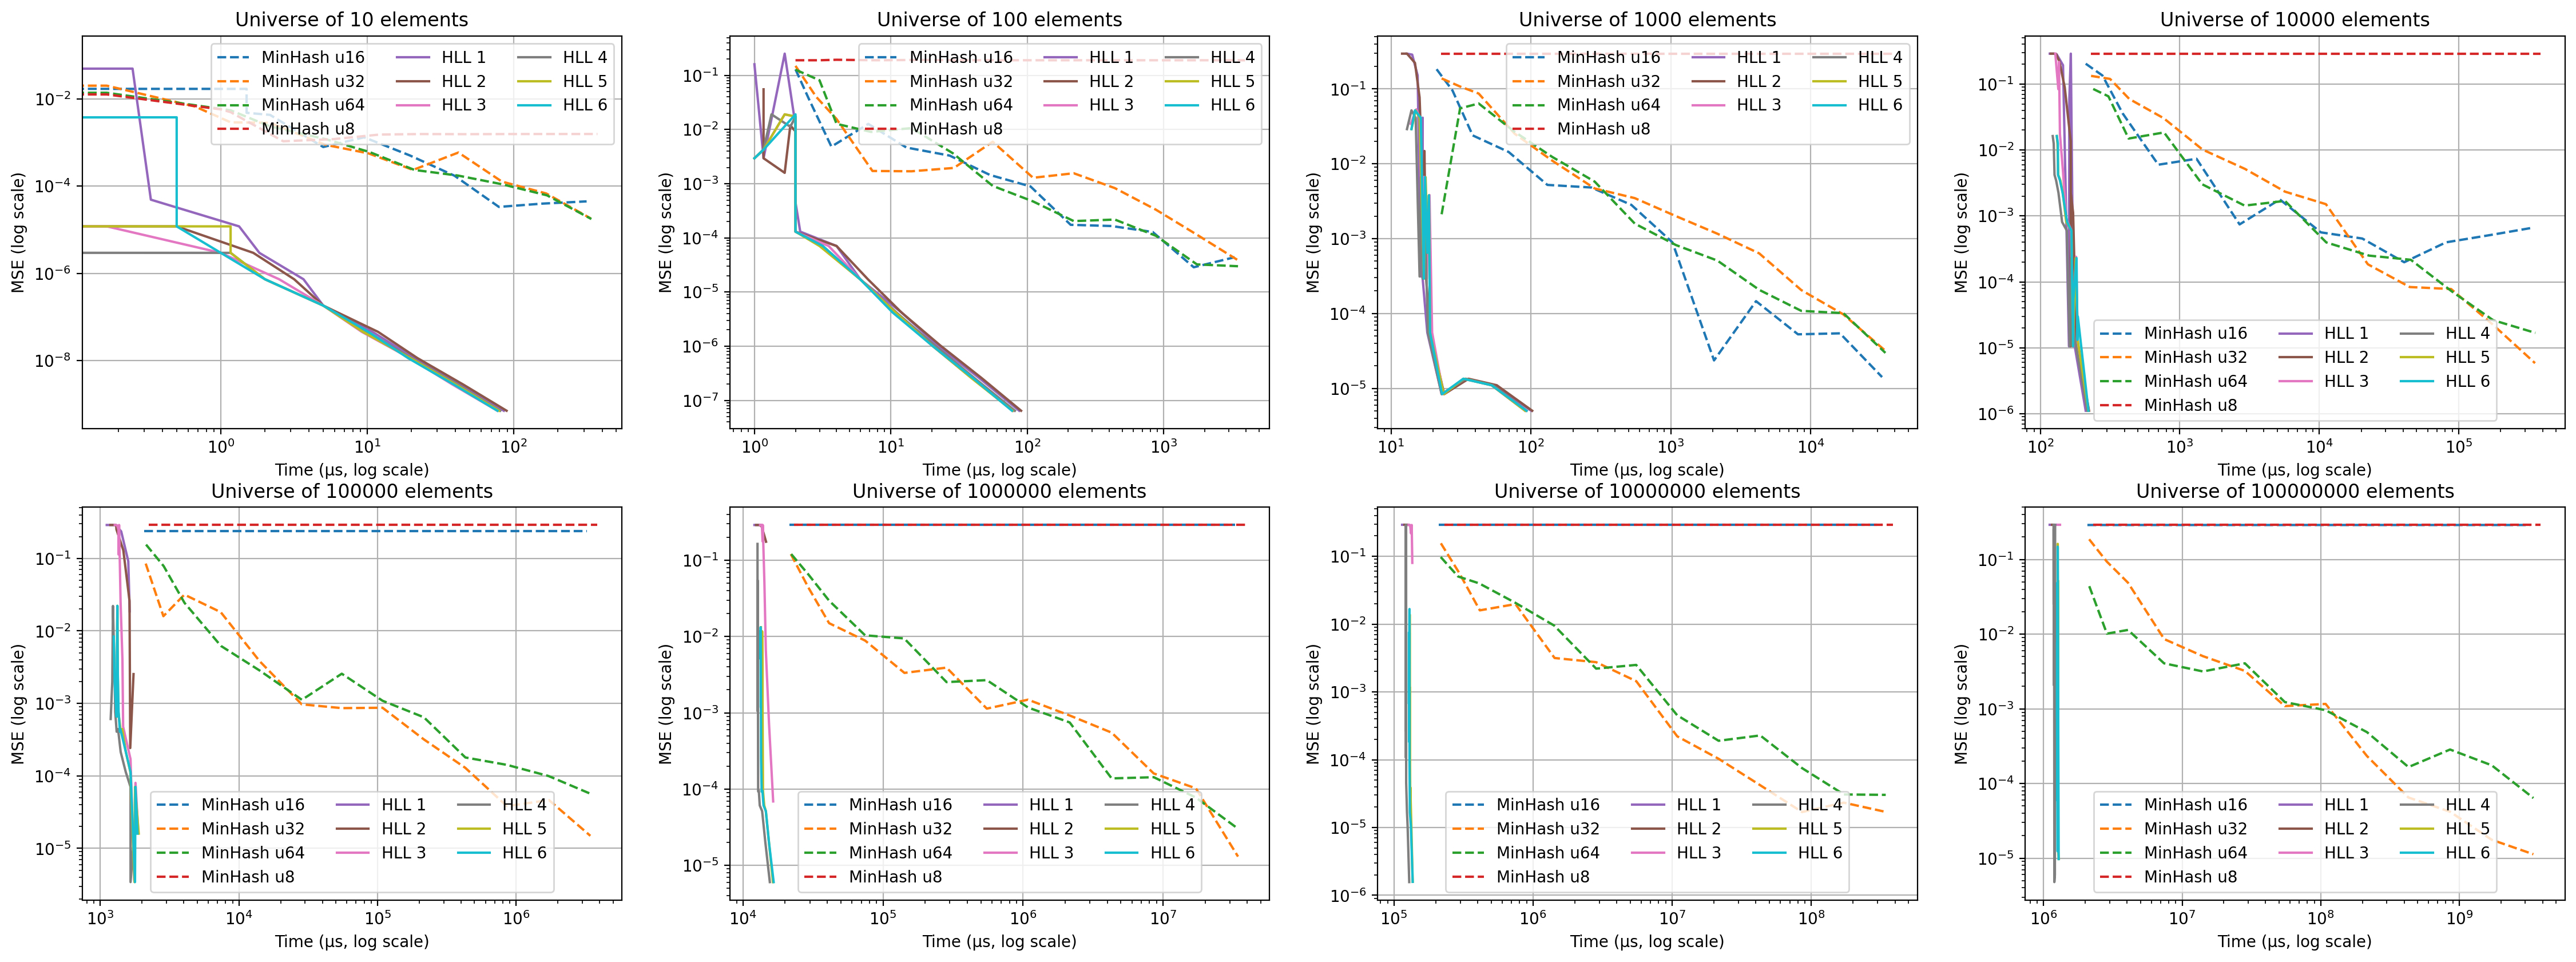

In [14]:
plots_per_row = 4
number_of_rows = math.ceil(len(hll.elements.unique()) / plots_per_row)

fig, axes = plt.subplots(
    figsize=(plots_per_row*7, 5*number_of_rows),
    nrows=number_of_rows,
    ncols=plots_per_row,
    dpi=200
)

for elements, ax in zip(hll.elements.unique(), axes.flatten()):
    for word in minhash.word.unique():
        filtered = minhash[(minhash.word == word) & (minhash.elements == elements)].sort_values(("time", "mean"))
        ax.plot(
            filtered.time["mean"],
            filtered["mse"]["mean"],
            ls='--',
            label=f"MinHash {word}",
        )
    for bits in hll.bits.unique():
        filtered = hll[(hll.bits == bits)& (hll.elements == elements)].sort_values(("time", "mean"))
        ax.plot(
            filtered.time["mean"],
            filtered["mse"]["mean"],
            label=f"HLL {bits}",
        )
    ax.set_title(f"Universe of {elements} elements")
    ax.set_xlabel(f"Time (μs, log scale)")
    ax.set_ylabel(f"MSE (log scale)")
    ax.legend(ncol=3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()

plt.show()

## MSE multiplied by time per memory requirements
In the following cell we plot, for all different eight universe sizes, the MSE of the Jaccard Index estimation multiplied by the time requirements as a function of the memory requirements. We do so for both MinHash and HyperLogLog. Note that both the X and Y axes are in log scale. By plotting the MSE multiplied by the time requirements as a function of the memory requirements, we are able to actually see the weighted difference in performance of the two methods. We observe that, for all universe sizes, HyperLogLog (when used with registers of 5 or 6 bits) is preferable to MinHash when the considered metrics is MSE multiplied time required for all considered memory requirements.

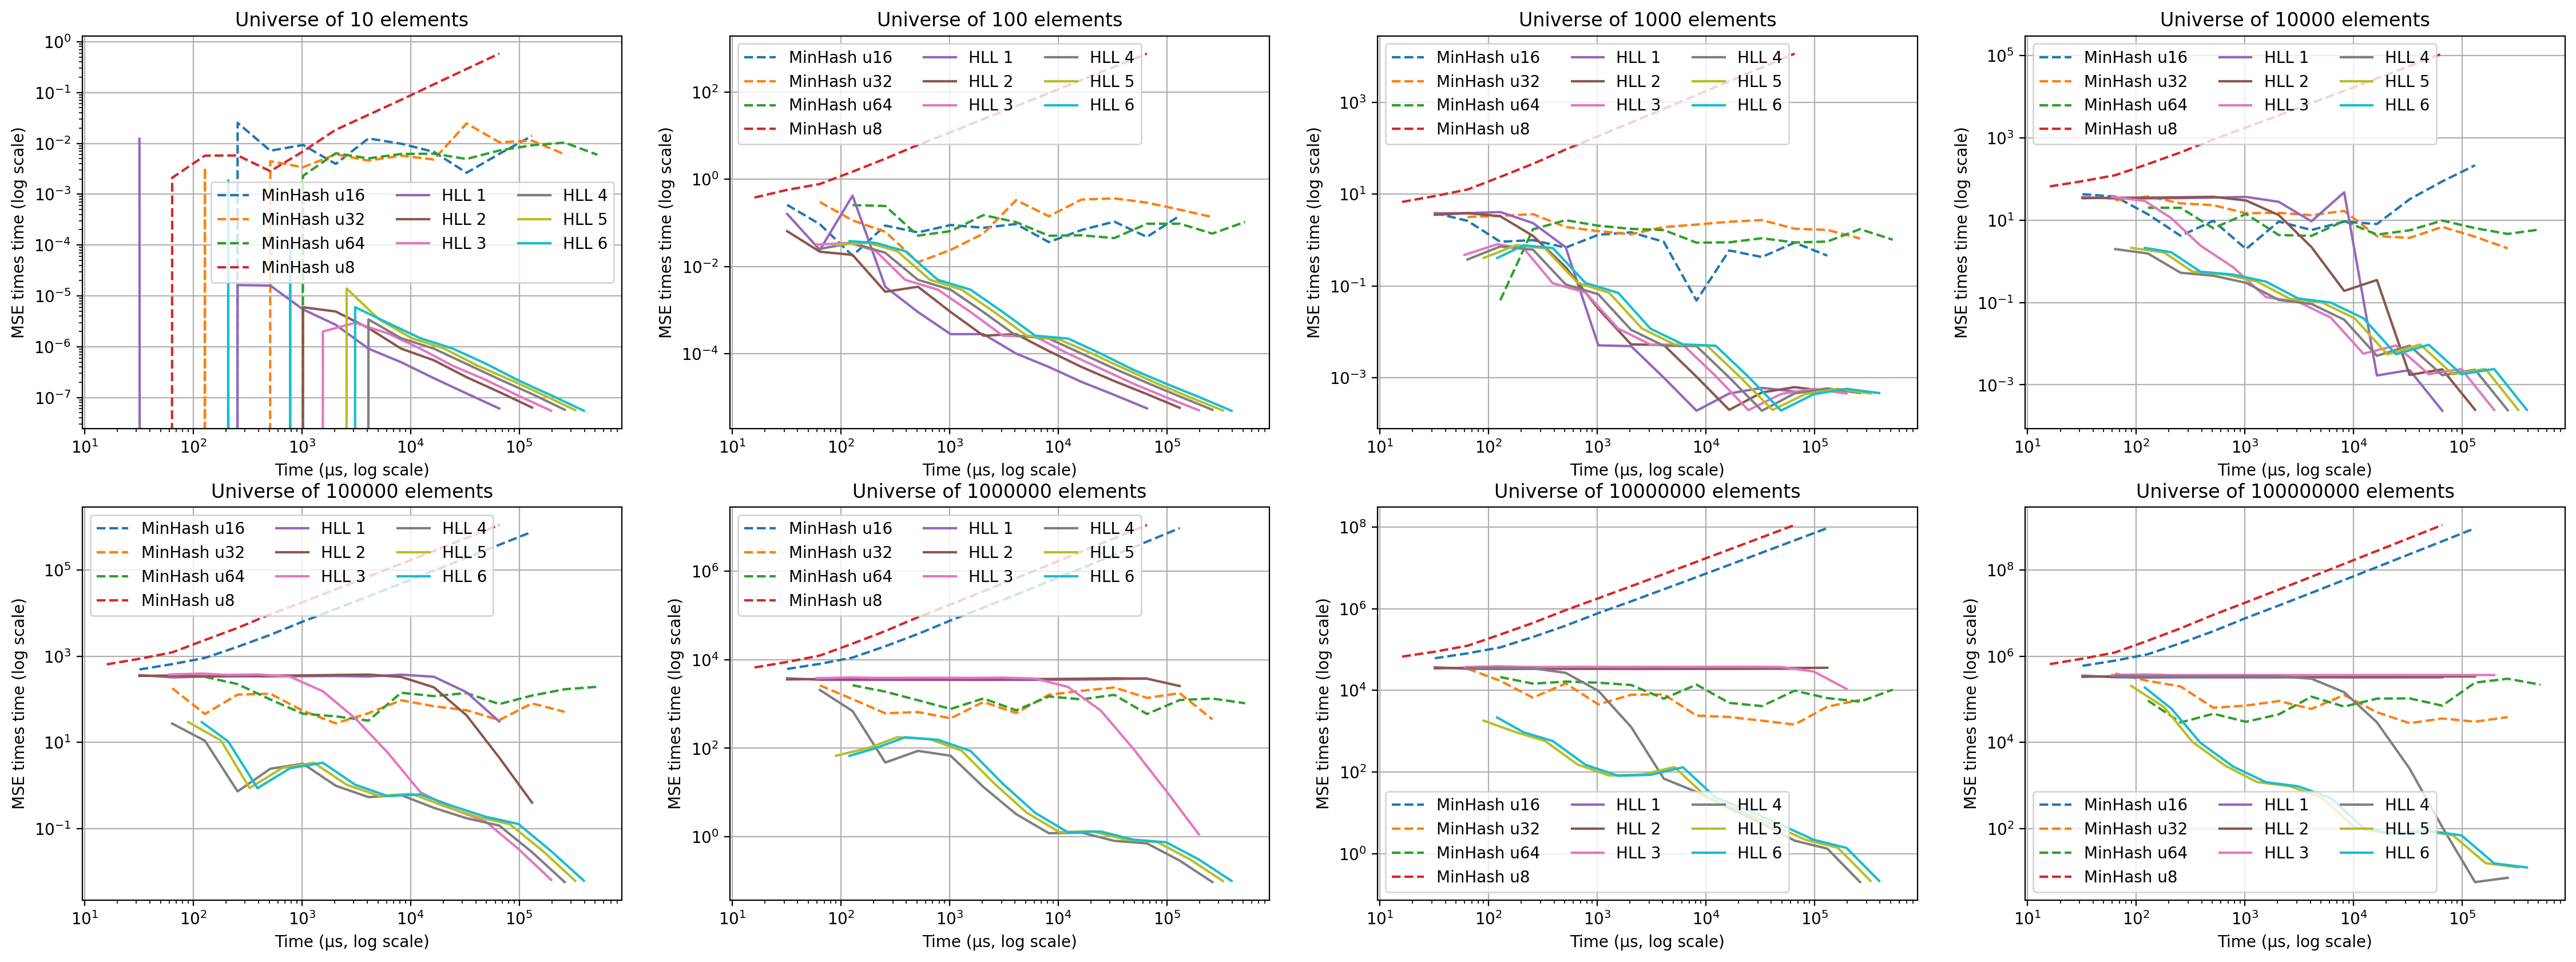

In [15]:
plots_per_row = 4
number_of_rows = math.ceil(len(hll.elements.unique()) / plots_per_row)

fig, axes = plt.subplots(
    figsize=(plots_per_row*7, 5*number_of_rows),
    nrows=number_of_rows,
    ncols=plots_per_row,
    dpi=200
)

flat_axes = iter(axes.flatten())

for elements, ax in zip(hll.elements.unique(), flat_axes):
    for word in minhash.word.unique():
        filtered = minhash[(minhash.word == word) & (minhash.elements == elements)].sort_values("memory")
        ax.plot(
            filtered.memory,
            filtered["mse"]["mean"] * filtered.time["mean"],
            ls='--',
            label=f"MinHash {word}",
        )
    for bits in hll.bits.unique():
        filtered = hll[(hll.bits == bits) & (hll.elements == elements)].sort_values("memory")
        ax.plot(
            filtered.memory,
            filtered["mse"]["mean"] * filtered.time["mean"],
            label=f"HLL {bits}",
        )
    ax.set_title(f"Universe of {elements} elements")
    ax.set_xlabel(f"Time (μs, log scale)")
    ax.set_ylabel(f"MSE times time (log scale)")
    ax.legend(ncol=3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()

for ax in flat_axes:
    ax.axis('off')

plt.show()

## Average MSE multiplied by time per memory requirements
While in the previous visualizations we explored the performance across different universe sizes, in this visualization we attempt to be more comprehensive and display the average performance across all considered universe sizes. We do so by plotting the average MSE multiplied by the time requirements as a function of the memory requirements. We do so for both MinHash and HyperLogLog. Note that both the X and Y axes are in log scale. By plotting the MSE multiplied by the time requirements as a function of the memory requirements, we are able to actually see the weighted difference in performance of the two methods. As seen before observe that, HyperLogLog (when used with registers of 5 or 6 bits) is preferable to MinHash.

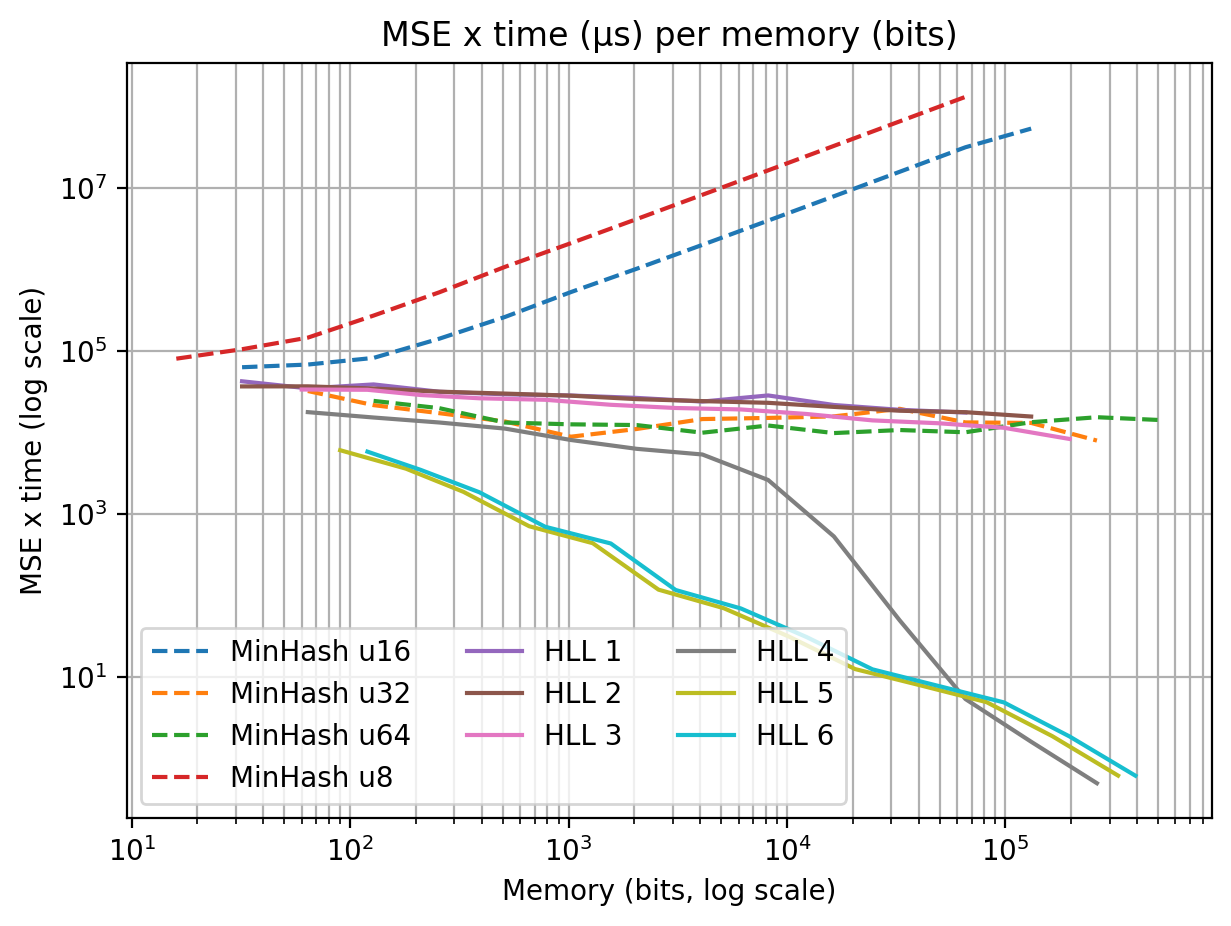

In [16]:
fig, axes = plt.subplots(
    figsize=(7, 5),
    dpi=200
)

for word in minhash_across_all.word.unique():
    filtered = minhash_across_all[(minhash_across_all.word == word)].sort_values("memory")
    axes.plot(
        filtered.memory,
        filtered["mse"]["mean"] * filtered["time"]["mean"],
        ls='--',
        label=f"MinHash {word}",
    )
for bits in hll_across_all.bits.unique():
    filtered = hll_across_all[(hll_across_all.bits == bits)].sort_values("memory")
    axes.plot(
        filtered.memory,
        filtered["mse"]["mean"] * filtered["time"]["mean"],
        label=f"HLL {bits}",
    )
axes.set_xlabel(f"Memory (bits, log scale)")
axes.set_ylabel(f"MSE x time (log scale)")
axes.legend(ncol=3)
axes.set_xscale("log")
axes.set_yscale("log")
axes.grid(which="both")

axes.set_title("MSE x time (μs) per memory (bits)")
plt.show()

## Conclusions
We have explored the performance of MinHash and HyperLogLog on the estimation of Jaccard Index. We have explored several MinHash parametrization, including different words (u8, u16, u32 and u64), and number of permutations. We have compared the performance of MinHash with the performance of several different parametrization of [HyperLogLog](https://github.com/LucaCappelletti94/hyperloglog-rs) so to determine the regions where, if any, MinHash is preferable to HyperLogLog. We have explored universes with different cardinalities, including 10, 100, 1000, 10k, 100k, 1M, 10M and 100M. We have compared the two main methods at parity of memory requirements and time requirements.

**From the benchmarks, it would seem that MinHash is hardly ever preferable to HyperLogLog counters for the goal of estimating Jaccard Indices.**

The difference is particularly significant when time performance is of the essence.

I hope that the tutorial was enjoyable to you. Please take a second of your time [to ⭐ the MinHash Rust GitHub repository](https://github.com/LucaCappelletti94/minhash-rs). If you would like to learn more [about HyperLogLog, checkout this other Rust GitHub repository providing the version we have used within these benchmarks](https://github.com/LucaCappelletti94/hyperloglog-rs).